In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score,roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10,6)
#show more columns in outputs
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)
DATA_PATH = "datasets/summit_dbe_processed.parquet"
df = pd.read_parquet(DATA_PATH)

In [3]:
y = df["is_failure"]
X = df.drop(columns=["is_failure"])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Failure count:", y.sum())
print("Normal count:", (y==0).sum())

X shape: (50259, 137)
y shape: (50259,)
Failure count: 295.0
Normal count: 49964


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
test_size=0.2,
random_state=42,
stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Failure rate in train:", y_train.mean())
print("Failure rate in test:", y_test.mean())

Train shape: (40207, 137)
Test shape: (10052, 137)
Failure rate in train: 0.005869624692217773
Failure rate in test: 0.005869478710704337


<b style="color:blue;">comment on output above:</b><br />
Stratification preserves the rare failure ratio in both splits.<br />
This avoids having zero failure cases in the test set.

In [ ]:
#handling class imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos

print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 169.36864406779662


<b style="color:blue;">comment on output above:</b><br />
The model must focus more on the rare positive failure samples.<br />
scale_pos_weight adjusts the learning process in favor of failures.

In [7]:
#Train XGBoost baseline model
model = XGBClassifier(
n_estimators=200,
max_depth=6,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
scale_pos_weight=scale_pos_weight,
random_state=42,
n_jobs=-1
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
#Evaluate threshold=0.5 (default)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0      0.997     0.998     0.997      9993
         1.0      0.547     0.492     0.518        59

    accuracy                          0.995     10052
   macro avg      0.772     0.745     0.758     10052
weighted avg      0.994     0.995     0.994     10052

ROC-AUC: 0.8694628612910393


In [9]:
#Tune prediction threshold
thresholds = [0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
for t in thresholds:
    preds = (y_prob > t).astype(int)
    print("Threshold:", t)
    print(classification_report(y_test, preds, digits=3))

Threshold: 0.2
              precision    recall  f1-score   support

         0.0      0.998     0.980     0.989      9993
         1.0      0.162     0.661     0.260        59

    accuracy                          0.978     10052
   macro avg      0.580     0.820     0.624     10052
weighted avg      0.993     0.978     0.985     10052

Threshold: 0.1
              precision    recall  f1-score   support

         0.0      0.998     0.940     0.968      9993
         1.0      0.067     0.729     0.123        59

    accuracy                          0.939     10052
   macro avg      0.533     0.834     0.546     10052
weighted avg      0.993     0.939     0.963     10052

Threshold: 0.05
              precision    recall  f1-score   support

         0.0      0.999     0.867     0.928      9993
         1.0      0.034     0.797     0.066        59

    accuracy                          0.867     10052
   macro avg      0.516     0.832     0.497     10052
weighted avg      0.993     

<b style="color:blue;">comment on output above:</b><br />
Lower thresholds increase recall for failures.<br />
In proactive fault tolerance, catching failures is more important than precision.

In [10]:
#Feature importance
importance = model.feature_importances_
idx = np.argsort(importance)[::-1][:20]

for i in idx:
    print(X.columns[i], importance[i])

power_range_5min 0.02737256
n_NA_power_6h 0.02721825
n_NA_power_1h 0.025665777
power_mean_1min 0.024388688
gpu_energy 0.01906095
core_temp_max_1min 0.01880345
mem_temp_min_1min 0.016019104
jobhours_1h 0.015382763
core_temp_range_15min 0.014794999
n_jobs_24h 0.014729382
mem_temp_mean_1h 0.013598395
mem_temp_mean_5min 0.013030003
n_zero_core_temp 0.013010644
mem_temp_max_1min 0.012914568
power_max_5min 0.012209533
core_temp_fluct_1min 0.011899903
mem_temp_fluct_5min 0.0116506675
job_range_power 0.0114836795
power_max_lifetime 0.010632975
core_temp_fluct_5min 0.010591948


<h3>PLOTTING BELOW</h3>

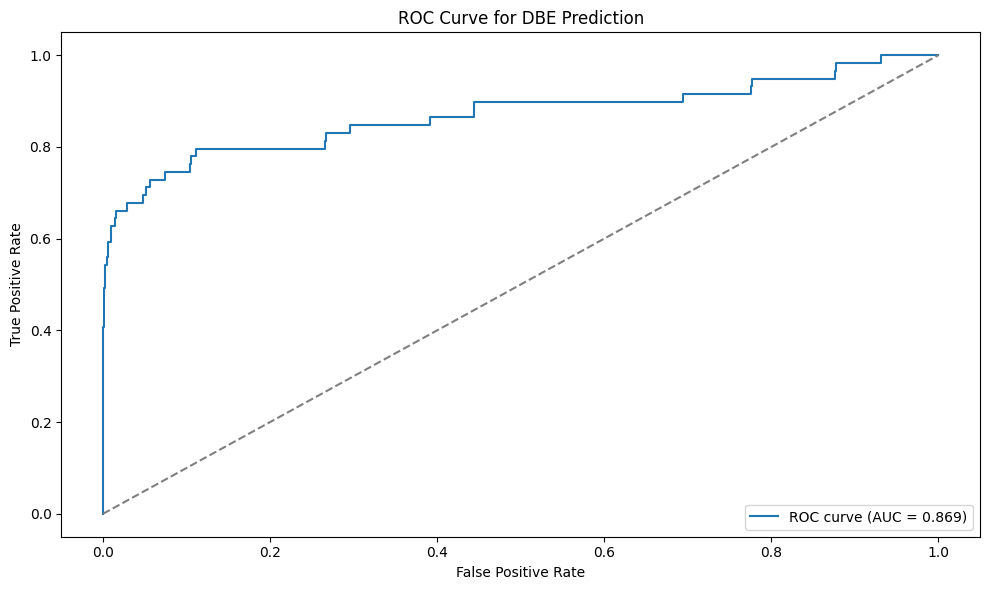

In [11]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for DBE Prediction")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The ROC curve compares the true positive rate and the false positive rate for different thresholds. The curve rises far above the diagonal baseline. The AUC score of about 0.869 shows that the model separates failure snapshots from normal snapshots with strong reliability.

<b>Key point to mention:</b><br/>
The model learns meaningful patterns in GPU telemetry. Even with rare failures, it maintains high separability between both classes.

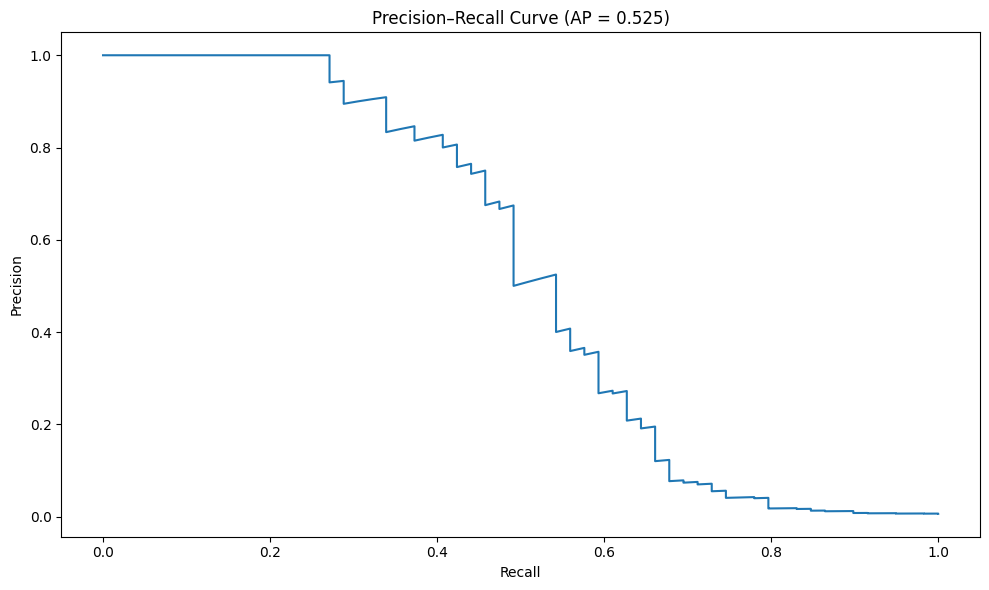

In [12]:
#Precision–Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The curve drops as recall increases. This is normal with rare events. The average precision score of about 0.525 shows that the model keeps reasonable precision while retrieving a large portion of failure cases.

<b>Key point to mention:</b><br/>
The curve highlights the tradeoff between catching more failures and producing more false alarms. This helps choose a threshold that fits proactive fault tolerance.

In [ ]:
#Threshold vs Recall Plot

thresholds = np.linspace(0.001, 0.5, 100)
recalls = []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    r = (preds[y_test==1]==1).mean()
    recalls.append(r)

plt.figure()
plt.plot(thresholds, recalls)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
Recall drops as the threshold increases. Low thresholds produce high recall because the model marks more samples as failures. High thresholds reduce recall and miss many failures.

<b>Key point to mention:</b><br/>
This plot helps select an operating threshold. A threshold around 0.1 reaches about 0.73 recall and keeps the system usable, which fits proactive detection goals.

In [ ]:
#Feature Importance (Top 20)
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,8))
plt.barh(np.array(X.columns)[idx][::-1], importances[idx][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The model ranks power and temperature instability features as the most predictive. Short-term changes in power and temperature, missing telemetry counts, and job-level power metrics appear at the top.

<b>Key point to mention:</b><br/>
These features capture stress patterns on GPU hardware. They align with known DBE behavior where thermal spikes, power fluctuations, and unstable sensor readings precede failures.

In [ ]:
#Correlation Heatmap (Top 20 Features)
top20_features = X.columns[idx]

corr = X[top20_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Top 20 Predictive Features")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
Some temperature and power features show strong correlations. Short-term temperature features cluster together. Missing telemetry counts also correlate with each other.

<b>Key point to mention:</b><br/>
These relationships show that DBE-related signals do not appear in isolation. They reflect combined effects of thermal changes, power shifts, and unstable readings before a failure.